<a href="https://colab.research.google.com/github/abdulrehman1215/Assignment-2/blob/main/Assignment2_EfficientNetB3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Connect To Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Untar dataset

In [ ]:
!tar -xvf "/content/drive/MyDrive/Assignment2 data/train_and_val_set.tar"

In [ ]:
!tar -xvf "/content/drive/MyDrive/Assignment2 data/test_set.tar"

# Loading Data

In [ ]:
import glob,os
import numpy as np
train_val_path = '/content/train_set/'

data_train_val = []
        
for anno in glob.glob(train_val_path + 'images/*.jpg'):
  idx = os.path.basename(anno).split('.')[0]
  img_path = os.path.join(train_val_path,f'images/{idx}.jpg')
  label = int(np.load(train_val_path + 'annotations/' + idx + '_exp.npy'))
  valence = float(np.load(train_val_path + 'annotations/' + idx + '_val.npy'))
  arousal = float(np.load(train_val_path + 'annotations/' + idx + '_aro.npy'))
  data_train_val.append([img_path,label,valence,arousal])

In [ ]:
import pandas as pd
train_val_df = pd.DataFrame(data = data_train_val,columns = ['img_path','label','valence','arousal'])

In [ ]:
train_val_df.head()

img_path  label   valence   arousal
0  /content/train_set/images/332455.jpg      1  0.861401  0.096787
1   /content/train_set/images/26690.jpg      1  0.526759  0.142225
2  /content/train_set/images/119245.jpg      1  0.666667  0.246032
3   /content/train_set/images/56912.jpg      0  0.007937 -0.007937
4  /content/train_set/images/228932.jpg      6 -0.611111  0.293651

In [ ]:
for i in range(8):
  dir_path = 'train/' + str(i)
  os.makedirs(dir_path)

In [ ]:
import shutil
for i in range(8):
  for c in list(train_val_df[train_val_df['label']== i]['img_path']):
    get_image = os.path.join('/content/train_set/images/', c)
    move_image = shutil.copy(get_image, '/content/train/' + str(i))

In [ ]:
import keras
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout

# Keras DataLoader

In [ ]:
train_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/train/',
    labels='inferred',
    label_mode = 'categorical',
    batch_size=200,
    image_size=(224,224)
)

Found 287651 files belonging to 8 classes.


In [ ]:
test_path = '/content/val_set/'

data_test = []
        
for anno in glob.glob(test_path + 'images/*.jpg'):
  idx = os.path.basename(anno).split('.')[0]
  img_path = os.path.join(test_path,f'images/{idx}.jpg')
  label = int(np.load(test_path + 'annotations/' + idx + '_exp.npy'))
  valence = float(np.load(test_path + 'annotations/' + idx + '_val.npy'))
  arousal = float(np.load(test_path + 'annotations/' + idx + '_aro.npy'))
  data_test.append([img_path,label,valence,arousal])

test_df = pd.DataFrame(data = data_test,columns = ['img_path','label','valence','arousal'])
for i in range(8):
  dir_path = 'test/' + str(i)
  os.makedirs(dir_path)

for i in range(8):
  for c in list(test_df[test_df['label']== i]['img_path']):
    get_image = os.path.join('/content/val_set/images/', c)
    move_image = shutil.copy(get_image, '/content/test/' + str(i))


val_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/test/',
    labels='inferred',
    label_mode = 'categorical',
    batch_size=200,
    image_size=(224,224)
)

Found 3999 files belonging to 8 classes.


# Normalize The Data

In [ ]:
import tensorflow as tf
def process(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

train_ds = train_ds.map(process)
val_ds = val_ds.map(process)

In [5]:
from keras.applications import EfficientNetB3
from keras.layers import Flatten,Dense,Dropout

base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the weights of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add your own classification and regression layers
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(8,activation='softmax')(x)

In [6]:
from keras.models import Model

model = Model(inputs=base_model.input, outputs=x)

# Visualize Model

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.75985 to fit



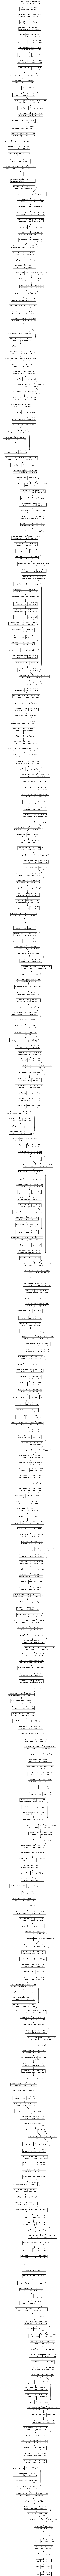

In [7]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

history = model.fit(train_ds,epochs=4, validation_data=val_ds)

Epoch 1/4
1439/1439 [==============================] - 1112s 755ms/step - loss: 1.5764 - accuracy: 0.4594 - val_loss: 2.7654 - val_accuracy: 0.1250
Epoch 2/4
1439/1439 [==============================] - 1072s 744ms/step - loss: 1.4886 - accuracy: 0.4670 - val_loss: 2.6469 - val_accuracy: 0.1250
Epoch 3/4
1439/1439 [==============================] - 1072s 744ms/step - loss: 1.4836 - accuracy: 0.4673 - val_loss: 2.7804 - val_accuracy: 0.1250
Epoch 4/4
1439/1439 [==============================] - 1082s 750ms/step - loss: 1.4810 - accuracy: 0.4673 - val_loss: 2.7715 - val_accuracy: 0.1250


# Save Model in google Drive

In [ ]:
model.save('/content/drive/MyDrive/Assignment2 data/vgg16_classification.h5' , save_format = 'h5')